Build-once factor model pipeline: load precomputed factor/alpha data, show the sector breakdown of the current portfolio, and summarize the style tilts that drive today’s stock picks.

Import core Python and plotting libraries plus the factor-model helpers; this cell wires the notebook into the existing systrat_factmod codebase and data folders.

In [1]:
import sys
from pathlib import Path

# Project root (one level ABOVE src)
PROJ_ROOT = Path(r"C:\Users\quantbase\Desktop\SyStrat_factmod")

if str(PROJ_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJ_ROOT))

print("Project root on sys.path:", PROJ_ROOT in map(Path, map(str, sys.path)))

from src.fm_config import DATA_INT
print("DATA_INT =", DATA_INT)

Project root on sys.path: True
DATA_INT = C:\Users\quantbase\Desktop\SyStrat_factmod\data_int


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#-------1. Load core artifacts (factor model outputs)---------

1.1 Load daily factor returns and the factor covariance matrix; this is the time-series view of how each style factor has actually been paying off historically.

1.2 Load the per-stock factor panel with SIZE, VAL, MOM, QUAL, technical factors, residual alpha, and risk estimates; this is the main table from which all rankings and sector breakdowns are derived.

In [ ]:
# Factor model outputs
factor_returns_us = pd.read_parquet(DATA_INT / "factor_returns_us.parquet")
factor_cov_us     = pd.read_parquet(DATA_INT / "factor_cov_us.parquet")
factor_resid_us   = pd.read_parquet(DATA_INT / "factor_residuals_us.parquet")

# Style panel + alpha panel + scores
factor_panel_us   = pd.read_parquet(DATA_INT / "factor_panel_us.parquet")
style_us_full     = pd.read_parquet(DATA_INT / "style_us_full.parquet")
alpha_panel_us    = pd.read_parquet(DATA_INT / "alpha_panel_us.parquet")
scores_us         = pd.read_parquet(DATA_INT / "scores_us.parquet")

factor_returns_us.head(), factor_cov_us, scores_us.tail()

(              market  sector_Communication Services  \
 date                                                  
 2021-11-02  0.001730                       0.001861   
 2021-11-03  0.004885                       0.006107   
 2021-11-04  0.007573                       0.001382   
 2021-11-05  0.005470                      -0.002796   
 2021-11-08  0.003165                      -0.005304   
 
             sector_Consumer Discretionary  sector_Consumer Staples  \
 date                                                                 
 2021-11-02                      -0.006513                 0.003607   
 2021-11-03                       0.011467                 0.001578   
 2021-11-04                       0.009735                 0.000330   
 2021-11-05                      -0.004071                -0.004284   
 2021-11-08                      -0.011729                -0.013222   
 
             sector_Energy  sector_Financials  sector_Health Care  \
 date                                 

In [6]:
last_date = scores_us["date"].max()
universe_today = scores_us.loc[scores_us["date"] == last_date].copy()

In [ ]:
ticker_case = "NFLX"

row_nflx = universe_today.loc[universe_today["ticker"] == ticker_case].iloc[0]

row_nflx[
    ["ticker", "sector", "S_long", "mu_factor", "alpha_resid", "sigma",
     "SIZE", "VAL", "MOM", "QUAL", "ROE_z", "GM_z", "CashEY_z", "LEV_z"]
]

ticker                           NFLX
sector         Communication Services
S_long                       2.088306
mu_factor                    0.010621
alpha_resid                  0.000056
sigma                        0.020105
SIZE                        -0.022729
VAL                         -0.908427
MOM                          0.748138
QUAL                        -0.952108
ROE_z                       -0.044517
GM_z                        -0.334439
CashEY_z                    -1.035844
LEV_z                       -0.101955
Name: 48944, dtype: object

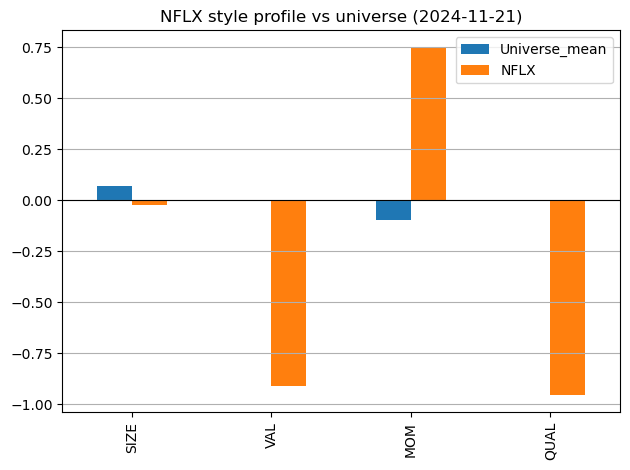

In [ ]:
# Bar plot of its style z-scores vs cross-section mean for that day:

style_focus = ["SIZE", "VAL", "MOM", "QUAL"]

mean_style = universe_today[style_focus].mean()
nflx_style = row_nflx[style_focus]

df_cmp = pd.DataFrame({"Universe_mean": mean_style, "NFLX": nflx_style})

ax = df_cmp.plot(kind="bar")
ax.set_title(f"{ticker_case} style profile vs universe ({last_date.date()})")
ax.axhline(0.0, color="black", linewidth=0.8)
ax.grid(axis="y")
plt.tight_layout()

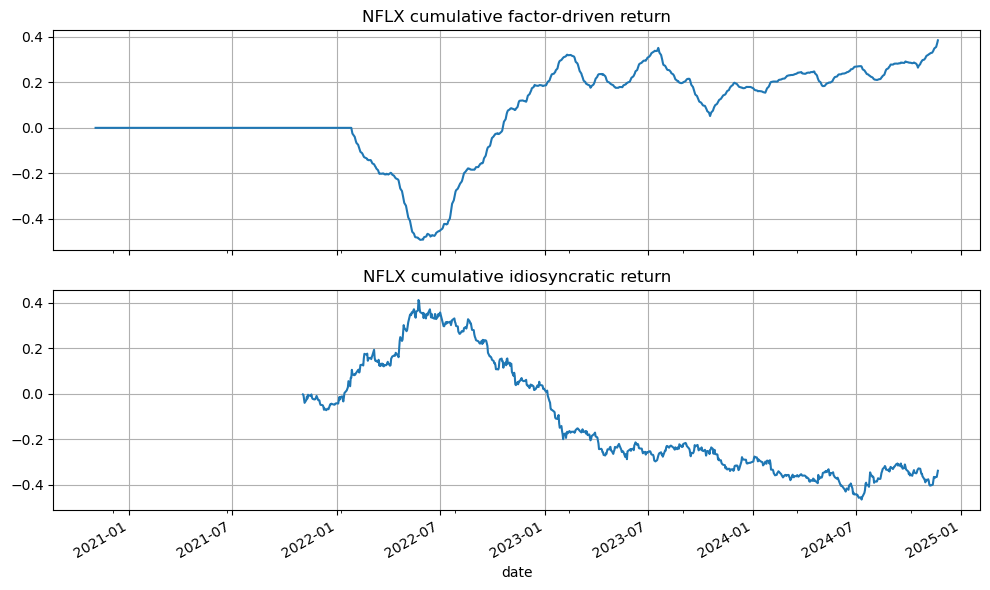

In [ ]:
# NFLX factor vs idiosyncratic time-series

alpha_nflx = (
    alpha_panel_us
    .loc[alpha_panel_us["ticker"] == ticker_case]
    .set_index("date")
    .sort_index()
)

resid_nflx = factor_resid_us[ticker_case].sort_index()

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

alpha_nflx["mu_factor"].cumsum().plot(ax=axes[0])
axes[0].set_title(f"{ticker_case} cumulative factor-driven return")
axes[0].grid(True)

resid_nflx.cumsum().plot(ax=axes[1])
axes[1].set_title(f"{ticker_case} cumulative idiosyncratic return")
axes[1].grid(True)

plt.tight_layout()



In [13]:
# NFLX single-day factor decomposition


# Exposures on last_date
exp_cols = ["SIZE", "VAL", "MOM", "QUAL", "EMA20_GAP", "VOL_Z", "LIQ"]
exp_nflx = (
    style_us_full
    .loc[(style_us_full["date"] == last_date) & (style_us_full["ticker"] == ticker_case),
         exp_cols]
    .iloc[0]
)

# Factor returns on last_date
fac_last = factor_returns_us.loc[last_date, ["market"] + exp_cols]

# Simple linear decomposition: r_hat = market + sum(exp_j * f_j)
contrib = exp_nflx * fac_last[exp_cols]
contrib["market"] = fac_last["market"]

contrib


SIZE         0.000077
VAL          0.001114
MOM          0.000825
QUAL        -0.002182
EMA20_GAP    0.004605
VOL_Z       -0.000861
LIQ         -0.000632
market       0.007426
dtype: float64

In [14]:
resid_last = factor_resid_us.loc[last_date, ticker_case]
resid_last

np.float64(0.013344054607738607)

In [ ]:
#----------------------------------------------------------------------------------